<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np
from os.path import isfile

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts, DS_KWARGS
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.03
prec = LIMIT_PROP * 100

DS_ITEM_COUNTS_PATH = f"nlp/data/{prec}%_wikicorpus_2-grams.npz"

config={
        'ds_name': 'wikicorpus',
        'embed_type': 'Glove',
        'embed_dim': 50,
        'op': 'concat',
        'n': 2,
        "limit_prop": 0.03,
        'num_workers': 22,
        "hidden_dim": 64,
        "dropout_prob": 0.0,
        "optim": Adam,
        "learning_rate": 0.001,
        "batch_size": 128
        }

In [3]:
### Get bigrams for wikicorpus. we only used 3% of the data as dataset is huge

if not isfile(DS_ITEM_COUNTS_PATH):
    save_ngram_counts(cache=DS_ITEM_COUNTS_PATH, config=config, **DS_KWARGS[DS_NAME]);

# Actual Bigrams Frequency

there are 1146052 bigrams


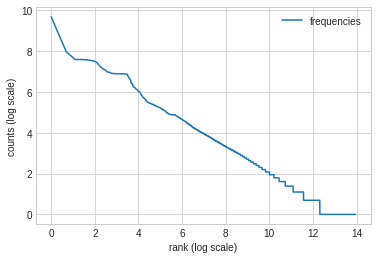

In [4]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies')

In [5]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('100 females', 1954), ('65 years', 1982), ('0 till', 1985), ('median income', 2885), ('external links', 16118)]
Bottom 5 frequent bigrams and their counts:
[('purely sacerdotal', 1), ('vehicle shall', 1), ('vehicle insignia', 1), ('vehicle trade', 1), ('vehicle proved', 1)]


# Evaluate Original Count-Min and Count-Sketch

In [3]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 7 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [4]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/3.0%_wikicorpus_2-grams.npz
data #: 1146052, shape (1146052,)
positive ratio: 1.72754, max 16118.000000, min 1.000000


count_sketch: # hashes 1, # buckets 175000 - loss 5.30	 time: 70.22 sec
count_sketch: # hashes 1, # buckets 25000 - loss 20.24	 time: 70.65 sec
count_sketch: # hashes 1, # buckets 400000 - loss 2.93	 time: 70.70 sec
count_sketch: # hashes 1, # buckets 750000 - loss 1.83	 time: 70.85 sec
count_sketch: # hashes 1, # buckets 100000 - loss 7.81	 time: 72.54 sec
count_sketch: # hashes 2, # buckets 25000 - loss 18.06	 time: 74.72 sec
count_sketch: # hashes 1, # buckets 250000 - loss 4.14	 time: 76.06 sec
count_sketch: # hashes 1, # buckets 1000000 - loss 1.52	 time: 69.86 sec
count_sketch: # hashes 1, # buckets 50000 - loss 12.60	 time: 71.13 sec
count_sketch: # hashes 1, # buckets 450000 - loss 2.79	 time: 71.35 sec
count_sketch: # hashes 1, # buckets 200000 - loss 4.84	 time: 72.46 sec
count_sketch: # hashes 1, # buckets 300000 - loss 3.66	 time: 6

In [ ]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

# Train Estimation Model

## Model Structure

![title](nlp/model.png)

In [ ]:
targets, preds, model_size = train_simple_model(config=config,
        args={
            'max_epochs': 10
            })

### Model Size

In [ ]:
print(f'Trained model size is : {model_size} MB')

In [ ]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [ ]:
TEST_RESULTS =[f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
VALID_RESULTS = [f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
TEST_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_test.npz"]
VALID_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz"]
LOOKUP_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_train.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 7
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [ ]:
print('Running: no lookup, only using learned model count min...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

In [ ]:
print('Running: perfect oracle... only using learned model count min...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

# Plot Count-Min

In [ ]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=None,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [ ]:
print('Running: no lookup, only using learned model count sketch...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

In [ ]:
print('Running: perfect oracle... only using learned model count sketch...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

# Plot Count-Sketch

In [ ]:
ALGO = 'Count-Sketch'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [model_size]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=None,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [ ]:
base = 'param_results/'
for i, path in enumerate(('count_sketch/cmin_wikicorpus.npz', 'cutoff_count_sketch_param/cmin_wikicorpus_test.npz',\
    'count_min/cmin_wikicorpus.npz', 'cutoff_count_min_param/cmin_wikicorpus_test.npz')):
    print(path, '\n')
    csketch = np.load(base + path)
    print('space_list\n', csketch['space_list'])
    if i % 2 == 0:
        print('loss_all\n', np.amin(csketch['loss_all'], axis=0), '\n\n')
    else:
        print('loss_all\n', csketch['loss_all'], '\n\n')
